## Application of `Geoplanar`

### Example US and Canada

### Fixing Gaps

In this notebook uses the appended original two countries data from US/Canada data (Not Planar Enforced). 
Additional reference: Notebook File0_dataprocessing.ipynb  

#### Steps
1. Data Retreival
2. Check the presence of gaps using geoplanar
3. Fixing the issues of gaps using geoplanar
3. Selectively fixing one or more gaps using geoplanar


In [1]:
import geoplanar
import geopandas as gpd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1. Data Retrieval 

In [3]:
df= gpd.read_parquet("../../geoplanar/datasets/uscan/uscan_1.parquet")
df.head()

,index,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry,...,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,0,20.750,34.956,1.0,1.0,Washington,53,Pacific,WA,"MULTIPOLYGON (((-122.40075 48.22540, -122.4615...",...,None,None,None,None,None,None,None,None,None,None
1,1,45.132,34.527,2.0,2.0,Montana,30,Mtn,MT,"POLYGON ((-111.47463 44.70224, -111.48001 44.6...",...,None,None,None,None,None,None,None,None,None,None
2,2,9.571,18.899,3.0,3.0,Maine,23,N Eng,ME,"MULTIPOLYGON (((-69.77779 44.07407, -69.86044 ...",...,None,None,None,None,None,None,None,None,None,None
3,3,21.874,21.353,4.0,4.0,North Dakota,38,W N Cen,ND,"POLYGON ((-98.73006 45.93830, -99.00645 45.939...",...,None,None,None,None,None,None,None,None,None,None
4,4,22.598,22.746,5.0,5.0,South Dakota,46,W N Cen,SD,"POLYGON ((-102.78793 42.99532, -103.00541 42.9...",...,None,None,None,None,None,None,None,None,None,None


In [4]:
df.columns

Index(['index', 'AREA', 'PERIMETER', 'STATE_', 'STATE_ID', 'STATE_NAME',
       'STATE_FIPS', 'SUB_REGION', 'STATE_ABBR', 'geometry', 'COUNTRY',
       'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1'],
      dtype='object')

<AxesSubplot:>

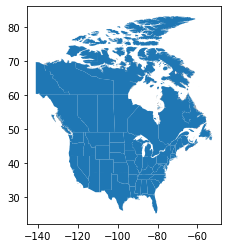

In [5]:
df.plot()

In [6]:
df.shape

(61, 21)

### 2. Detecting Gaps

In [7]:
gaps=geoplanar.gaps(df) # identifying all the gaps

In [8]:
gaps.shape

(133, 1)

Geoplanar detected a total of 133 total gaps in the merged country dataset that are located on the border. The data is plotted below: 

<AxesSubplot:>

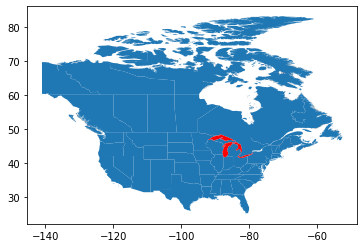

In [9]:
base = df.plot()
gaps.plot(color='red', ax=base) 

The Great Lakes appear as gaps in the data, since they represent water bodies and not a data issue we want to append them on the original data and assign a country label "Lakes". But first we need to find the polygons that represent these lakes.

### 2. Checking the Area and Location of the Gaps

In [10]:
gaps.head()

,geometry
1,"POLYGON ((-79.05679 43.23756, -79.05059 43.204..."
2,"POLYGON ((-79.04915 43.19638, -79.03956 43.144..."
3,"POLYGON ((-78.90668 42.90353, -78.85944 42.792..."
4,"POLYGON ((-101.38350 49.00008, -101.36248 49.0..."
5,"POLYGON ((-114.06977 49.00006, -114.06929 49.0..."


In [11]:
gaps.area

1      0.000059
2      0.012665
3      1.396759
4      0.004073
5      0.001917
         ...   
129    0.010377
130    0.000867
131    0.000158
132    0.000155
133    0.000009
Length: 133, dtype: float64

In [12]:
gaps.total_bounds # gives the total bounds of the locations of gaps

array([-118.98705715,   41.39128876,  -67.24041383,   49.38329697])

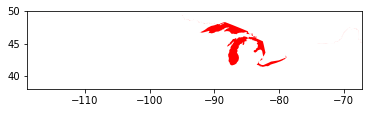

In [13]:
base = gaps.plot(color='red')
_ = base.set_xlim(-118.98705715, -67.24041383)
_ = base.set_ylim(38, 50)

In [14]:
y=gaps.buffer(1) # buffers make it easy to detect small polygons that are not clearly visible above

<AxesSubplot:>

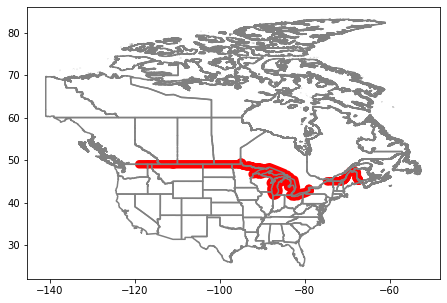

In [15]:
base = df.geometry.boundary.plot(edgecolor='grey', figsize=(9, 5))
y.plot(ax=base, color='red')

<AxesSubplot:>

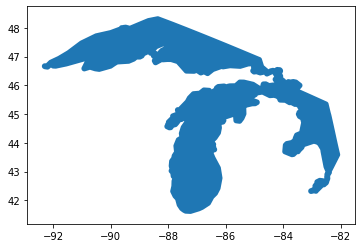

In [16]:
lakes = gaps.iloc[[58,63, 62]]
lakes_buffer=lakes.buffer(0.1)
lakes_buffer.plot()

In [17]:
gaps_cen= gaps.centroid

<AxesSubplot:>

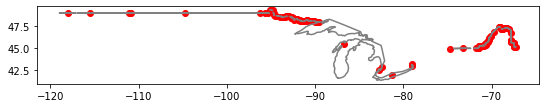

In [18]:
base = gaps.geometry.boundary.plot(edgecolor='grey', figsize=(9, 5))
gaps_cen.plot(ax=base, color='red')


In [19]:
gaps_cen[50:70]

51    POINT (-90.48455 48.10092)
52    POINT (-90.31080 48.10530)
53    POINT (-90.17660 48.11166)
54    POINT (-90.13517 48.11132)
55    POINT (-89.98588 48.04698)
56    POINT (-89.81201 48.01459)
57    POINT (-89.77393 48.02149)
58    POINT (-89.60121 48.01212)
59    POINT (-86.77878 45.48012)
60    POINT (-95.32451 49.00004)
61    POINT (-95.62764 49.00003)
62    POINT (-96.24832 49.00018)
63    POINT (-82.46721 42.88151)
64    POINT (-82.75113 42.53461)
65    POINT (-73.22606 45.00624)
66    POINT (-71.78957 45.00963)
67    POINT (-71.50842 45.01762)
68    POINT (-74.74128 44.99196)
69    POINT (-68.92089 47.19575)
70    POINT (-68.87571 47.18833)
dtype: geometry

### 3. Appending Lakes as Separate Polygons on the data

In [20]:
#Assigning gaps [ 60,64 and 65] to the original data 
lakes['COUNTRY'] = 'LAKE'



In [21]:
lakes

,geometry,COUNTRY
59,"POLYGON ((-89.56835 47.99815, -89.53059 48.001...",LAKE
64,"POLYGON ((-82.92947 42.36300, -82.87499 42.458...",LAKE
63,"POLYGON ((-82.46070 42.90598, -82.46270 42.895...",LAKE


In [22]:
df_new = lakes.append(df)
df_new.reset_index(inplace=True )


In [23]:
df_new.describe()


,level_0,index,AREA,PERIMETER,STATE_,STATE_ID
count,64.000000,61.000000,48.000000,48.000000,48.000000,48.000000
mean,31.500000,19.770492,17.022792,22.912771,25.000000,25.000000
std,18.624101,14.449214,12.475875,10.849594,14.510451,14.510451
min,0.000000,0.000000,0.293000,3.643000,1.000000,1.000000
25%,15.750000,7.000000,10.367000,17.956500,12.750000,12.750000
50%,31.500000,17.000000,14.237000,21.886000,24.500000,24.500000
75%,47.250000,32.000000,22.690250,26.289500,37.250000,37.250000
max,64.000000,47.000000,65.060000,64.807000,51.000000,51.000000


<AxesSubplot:>

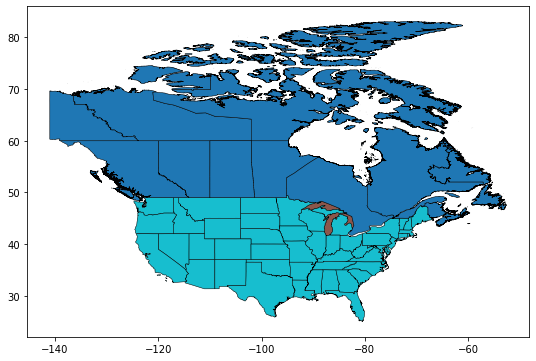

In [24]:
df_new.plot(column= 'COUNTRY', # Column name
             figsize=(9,9), # size of the figure
              edgecolor="black", # color of the outline
                  linewidth=0.5)

In [25]:
df.shape

(61, 21)

In [26]:
df_new.shape # 61 US and Canada Polygons and 134 gaps

(64, 22)

Once we append the lakes the observations increase from 61 to 64. 

## Geoplanar to Fill the Gaps

### 4. Filling all the Gaps in the Data

In [27]:
gaps_removed = geoplanar.fill_gaps(df_new) # df is the original data

In [28]:
gaps_new = geoplanar.gaps(gaps_removed)
gaps_new.shape

(0, 1)

<AxesSubplot:>

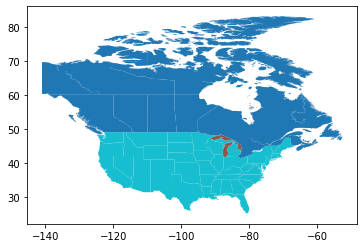

In [29]:
gaps_removed.plot(column= 'COUNTRY') # Here we filled the all the gaps

### Changing defaults

In [30]:
gaps_removed_new = geoplanar.fill_gaps(df_new ,largest=False)

In [31]:
gaps_new_2 = geoplanar.gaps(gaps_removed_new)
gaps_new_2.shape

(5, 1)

## Selective Filling of Gaps

### 6. Example 2: Selective Filling Gaps

In [37]:
selection2 = gaps[10:50]

In [38]:
selection2.head()

,geometry
11,"POLYGON ((-94.82143 49.31287, -94.82417 49.307..."
12,"POLYGON ((-94.68633 48.83725, -94.68104 48.877..."
13,"POLYGON ((-94.63043 48.74478, -94.69422 48.777..."
14,"POLYGON ((-94.54871 48.71326, -94.57011 48.713..."
15,"POLYGON ((-94.37949 48.71140, -94.37440 48.709..."


<AxesSubplot:>

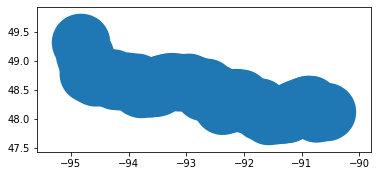

In [39]:
# visualize the polygons better with the buffer
s2=selection2.buffer(0.5)
s2.plot()

<AxesSubplot:>

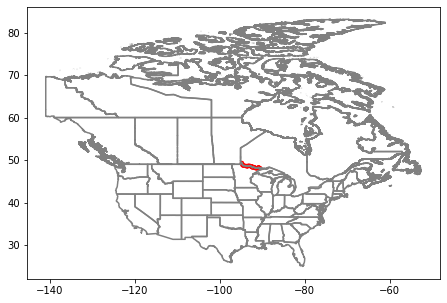

In [40]:
base = gaps_removed.geometry.boundary.plot(edgecolor='grey', figsize=(9, 5))
s2.plot(ax=base, color='red')

Here we have identified a set of polygons that we can fill instead of the single one.

In [41]:
selective_gaps_new= geoplanar.fill_gaps(df, selection2 ,  largest=False)

In [42]:
selective_gaps_removed_new = geoplanar.gaps(selective_gaps_new)


In [43]:
selective_gaps_removed_new.shape

(93, 1)

Here we have selectively filled polygons 10 to 59 and are left with 85 gaps out of the 134 total.

In [44]:
df.area.sum()

2510.1262380156013

In [45]:
selective_gaps_new.area.sum()

2510.154270333954

In [46]:
selection2.area.sum()

0.028032318353125293

The difference in areas original and selectively filled data precisely match the area of polygons filled.

### Saving Data

In [47]:
df_new.to_parquet("../../geoplanar/datasets/uscan/nonplanar_enforced.parquet")

In [48]:
gaps_removed_new.to_parquet("../../geoplanar/datasets/uscan/gaps_removed_nondefault.parquet")

In [49]:
gaps_removed.to_parquet("../../geoplanar/datasets/uscan/gaps_removed.parquet")